Using device: cuda
Reynolds number: 10000.0
Epoch 0, Loss: 0.24135
Epoch 100, Loss: 0.06285
Epoch 200, Loss: 0.03134
Epoch 300, Loss: 0.02971
Epoch 400, Loss: 0.02754
Epoch 500, Loss: 0.02620
Epoch 600, Loss: 0.02551
Epoch 700, Loss: 0.02504
Epoch 800, Loss: 0.02461
Epoch 900, Loss: 0.02511
Epoch 1000, Loss: 0.02381
Epoch 1100, Loss: 0.02297
Epoch 1200, Loss: 0.02374
Epoch 1300, Loss: 0.02191
Epoch 1400, Loss: 0.02146
Epoch 1500, Loss: 0.02102
Epoch 1600, Loss: 0.02176
Epoch 1700, Loss: 0.02012
Epoch 1800, Loss: 0.02013
Epoch 1900, Loss: 0.01980
Epoch 2000, Loss: 0.01899
Epoch 2100, Loss: 0.01861
Epoch 2200, Loss: 0.01809
Epoch 2300, Loss: 0.01858
Epoch 2400, Loss: 0.01724
Epoch 2500, Loss: 0.01692
Epoch 2600, Loss: 0.01602
Epoch 2700, Loss: 0.01591
Epoch 2800, Loss: 0.01510
Epoch 2900, Loss: 0.01477
Epoch 3000, Loss: 0.01467
Epoch 3100, Loss: 0.01606
Epoch 3200, Loss: 0.01351
Epoch 3300, Loss: 0.01540
Epoch 3400, Loss: 0.01249
Epoch 3500, Loss: 0.01207
Epoch 3600, Loss: 0.01169
Epoch 

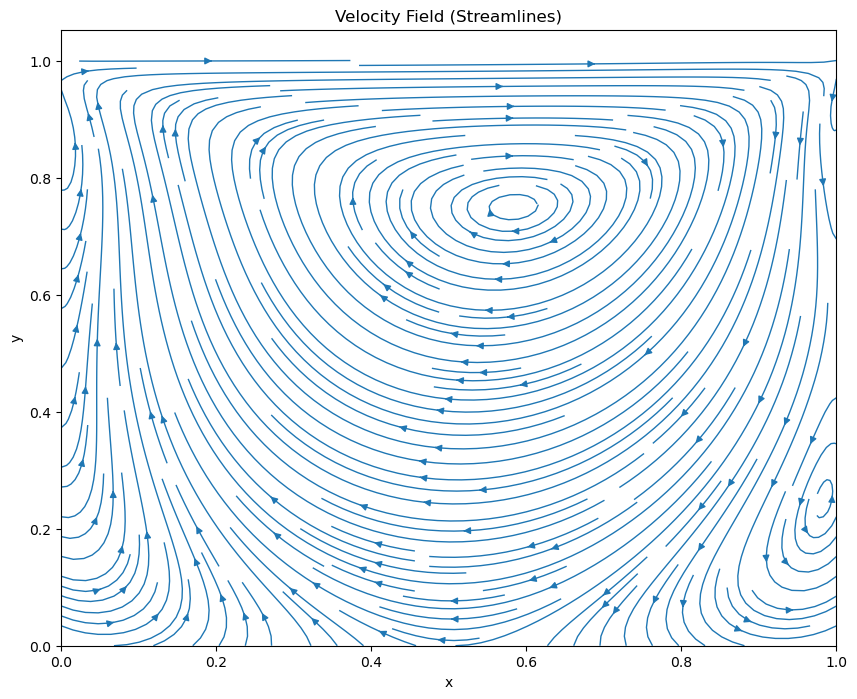

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Ensure GPU usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set random seeds
torch.manual_seed(42)
np.random.seed(42)

# Problem parameters
nu = 0.01
U_lid = 1.0
L = 100.0
Re_t = U_lid * L / nu
print(f"Reynolds number: {Re_t}")

# Domain boundaries
x_min, x_max = 0.0, 1.0
y_min, y_max = 0.0, 1.0

# Neural network definition
class TurbulentPINN(nn.Module):
    def __init__(self, num_hidden_layers=8, num_neurons_per_layer=40):
        super().__init__()
        layers = []
        input_dim = 2
        for _ in range(num_hidden_layers):
            layers.append(nn.Linear(input_dim, num_neurons_per_layer))
            layers.append(nn.Tanh())
            input_dim = num_neurons_per_layer
        self.hidden_layers = nn.Sequential(*layers)
        
        self.u_output = nn.Linear(num_neurons_per_layer, 1)
        self.v_output = nn.Linear(num_neurons_per_layer, 1)
        self.p_output = nn.Linear(num_neurons_per_layer, 1)

    def forward(self, inputs):
        X = self.hidden_layers(inputs)
        u = self.u_output(X)
        v = self.v_output(X)
        p = self.p_output(X)
        return u, v, p

# Data preparation
N_f = 10000
N_b = 2000

x_f = torch.FloatTensor(N_f, 1).uniform_(x_min, x_max).to(device)
y_f = torch.FloatTensor(N_f, 1).uniform_(y_min, y_max).to(device)
X_f_tensor = torch.cat([x_f, y_f], dim=1).requires_grad_(True)

# Boundary points
x_left = x_min * torch.ones(N_b // 4, 1).to(device)
y_left = torch.rand(N_b // 4, 1).to(device)
x_right = x_max * torch.ones(N_b // 4, 1).to(device)
y_right = torch.rand(N_b // 4, 1).to(device)
x_bottom = torch.rand(N_b // 4, 1).to(device)
y_bottom = y_min * torch.ones(N_b // 4, 1).to(device)
x_top = torch.rand(N_b // 4, 1).to(device)
y_top = y_max * torch.ones(N_b // 4, 1).to(device)

X_b_tensor = torch.cat([
    torch.cat([x_left, y_left], dim=1),
    torch.cat([x_right, y_right], dim=1),
    torch.cat([x_bottom, y_bottom], dim=1),
    torch.cat([x_top, y_top], dim=1)
]).to(device)


u_top = U_lid * torch.ones(N_b // 4, 1).to(device)
v_top = torch.zeros(N_b // 4, 1).to(device)
u_side = torch.zeros(3 * N_b // 4, 1).to(device)
v_side = torch.zeros(3 * N_b // 4, 1).to(device)

u_b_tensor = torch.cat([u_side, u_top]).to(device)
v_b_tensor = torch.cat([v_side, v_top]).to(device)

# Loss function
def loss_fn(model, X_f, X_b, u_b, v_b):
    u, v, p = model(X_f)
    u_b_pred, v_b_pred, _ = model(X_b)

    grads = torch.autograd.grad(outputs=[u.sum(), v.sum(), p.sum()], inputs=X_f, create_graph=True)
    u_grad = torch.autograd.grad(u.sum(), X_f, create_graph=True)[0]
    v_grad = torch.autograd.grad(v.sum(), X_f, create_graph=True)[0]
    p_grad = torch.autograd.grad(p.sum(), X_f, create_graph=True)[0]

    u_x, u_y = u_grad[:, 0], u_grad[:, 1]
    v_x, v_y = v_grad[:, 0], v_grad[:, 1]
    p_x, p_y = p_grad[:, 0], p_grad[:, 1]

    u_xx = torch.autograd.grad(u_x.sum(), X_f, create_graph=True)[0][:, 0]
    u_yy = torch.autograd.grad(u_y.sum(), X_f, create_graph=True)[0][:, 1]
    v_xx = torch.autograd.grad(v_x.sum(), X_f, create_graph=True)[0][:, 0]
    v_yy = torch.autograd.grad(v_y.sum(), X_f, create_graph=True)[0][:, 1]


    nu_eff = nu + 0.01
    continuity = u_x + v_y
    momentum_u = u.squeeze()*u_x + v.squeeze()*u_y + p_x - nu_eff*(u_xx+u_yy)
    momentum_v = u.squeeze()*v_x + v.squeeze()*v_y + p_y - nu_eff*(v_xx+v_yy)

    bc_loss = ((u_b_pred - u_b)**2).mean() + ((v_b_pred - v_b)**2).mean()
    pde_loss = (continuity**2).mean() + (momentum_u**2).mean() + (momentum_v**2).mean()

    return pde_loss + bc_loss

# Training setup
model = TurbulentPINN().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training loop
for epoch in range(10000):
    optimizer.zero_grad()
    loss = loss_fn(model, X_f_tensor, X_b_tensor, u_b_tensor, v_b_tensor)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.5f}")

# Visualization
def visualize_results(model):
    nx, ny = 50, 50
    x = np.linspace(x_min, x_max, nx)
    y = np.linspace(y_min, y_max, ny)
    X, Y = np.meshgrid(x, y)
    XY = torch.FloatTensor(np.vstack((X.flatten(), Y.flatten())).T).to(device)

    u_pred, v_pred, _ = model(XY)

    u_pred = u_pred.cpu().detach().numpy().reshape((ny, nx))
    v_pred = v_pred.cpu().detach().numpy().reshape((ny, nx))

    plt.figure(figsize=(10, 8))
    plt.streamplot(X, Y, u_pred, v_pred, density=2, linewidth=1, arrowsize=1)
    plt.title('Velocity Field (Streamlines)')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

visualize_results(model)
